In [1]:
import os
import sys
import seawater as sw
from scipy import interpolate as interp
from matplotlib import rc
rc('text',usetex=True)

sys.path.append("../scripts")
sys.path.append("..")

from extract import *

In [12]:
"""
Read data and compute means
"""
path = os.path.join("..","matlab",filename)
table = read_table(path)

#Define a slice of data
DSL = slice(15,80) # depth slice
sl = (slice(0,2000),DSL,slice(2,3),slice(2,3))

#Get state variables
N2 = extract_node(table,'N2')[sl]
T  = extract_node(table,'T')[sl]
S  = extract_node(table,'S')[sl]
W  = extract_node(table,'W')[sl]*100
Z  = extract_node(table,'z').flatten()[sl[1]]

#Compute Density from state variables
RP = sw.eos80.dens(S,T,2000)

TIME   = extract_node(table,'time').flatten()[sl[0]]
LAT    = extract_node(table,'lat')[:,0][sl[2]]
LON    = extract_node(table,'lon')[0,:][sl[3]]
DEPTH  = extract_node(table,'z').flatten()[sl[1]]

#Start time at zero
t0 = matlab2datetime(TIME[1]).timestamp()
TIME = [round(matlab2datetime(T).timestamp()-t0)/3600 for T in TIME]

#Form a coordinate matrix
AX = np.array(list(itertools.product(*[TIME,DEPTH,LAT,LON])),dtype=[('t',float),('z',float),('x',float),('y',float)])
AX = AX.reshape(T.shape)

In [3]:
"""
Compute means
"""
#Compute the mean stratification
N2_mean = np.mean(N2,axis=(0,2,3))
T_mean  = np.mean(T,axis=(0,2,3))
S_mean  = np.mean(S,axis=(0,2,3))
R_mean  = sw.eos80.dens(S_mean,T_mean,2000)
#R_mean  = sw.eos80.pden(S_mean[DSL],T_mean[DSL],Z[DSL],pr=2000)


#Create a function that is depth as a function of the mean density
zofr = interp.InterpolatedUnivariateSpline(R_mean,Z)
DZ   = AX['z'] - zofr(RP) 

In [144]:
"""
M2 band pass filter
"""
def bandpass_filter(center,half_width,fs,order=5):
    nyq = fs*0.5
    lo = (center-half_width/nyq)
    hi = (center+half_width/nyq)
    b, a = sig.butter(order, [lo, hi], btype='band')
    return b,a

M2  = .0805 
bw  = .02
b,a = bandpass_filter(M2,bw,1)
DZB = sig.lfilter(b,a,DZ,axis=0)
RPB = sig.lfilter(b,a,RP,axis=0)
WB = sig.lfilter(b,a,W,axis=0)



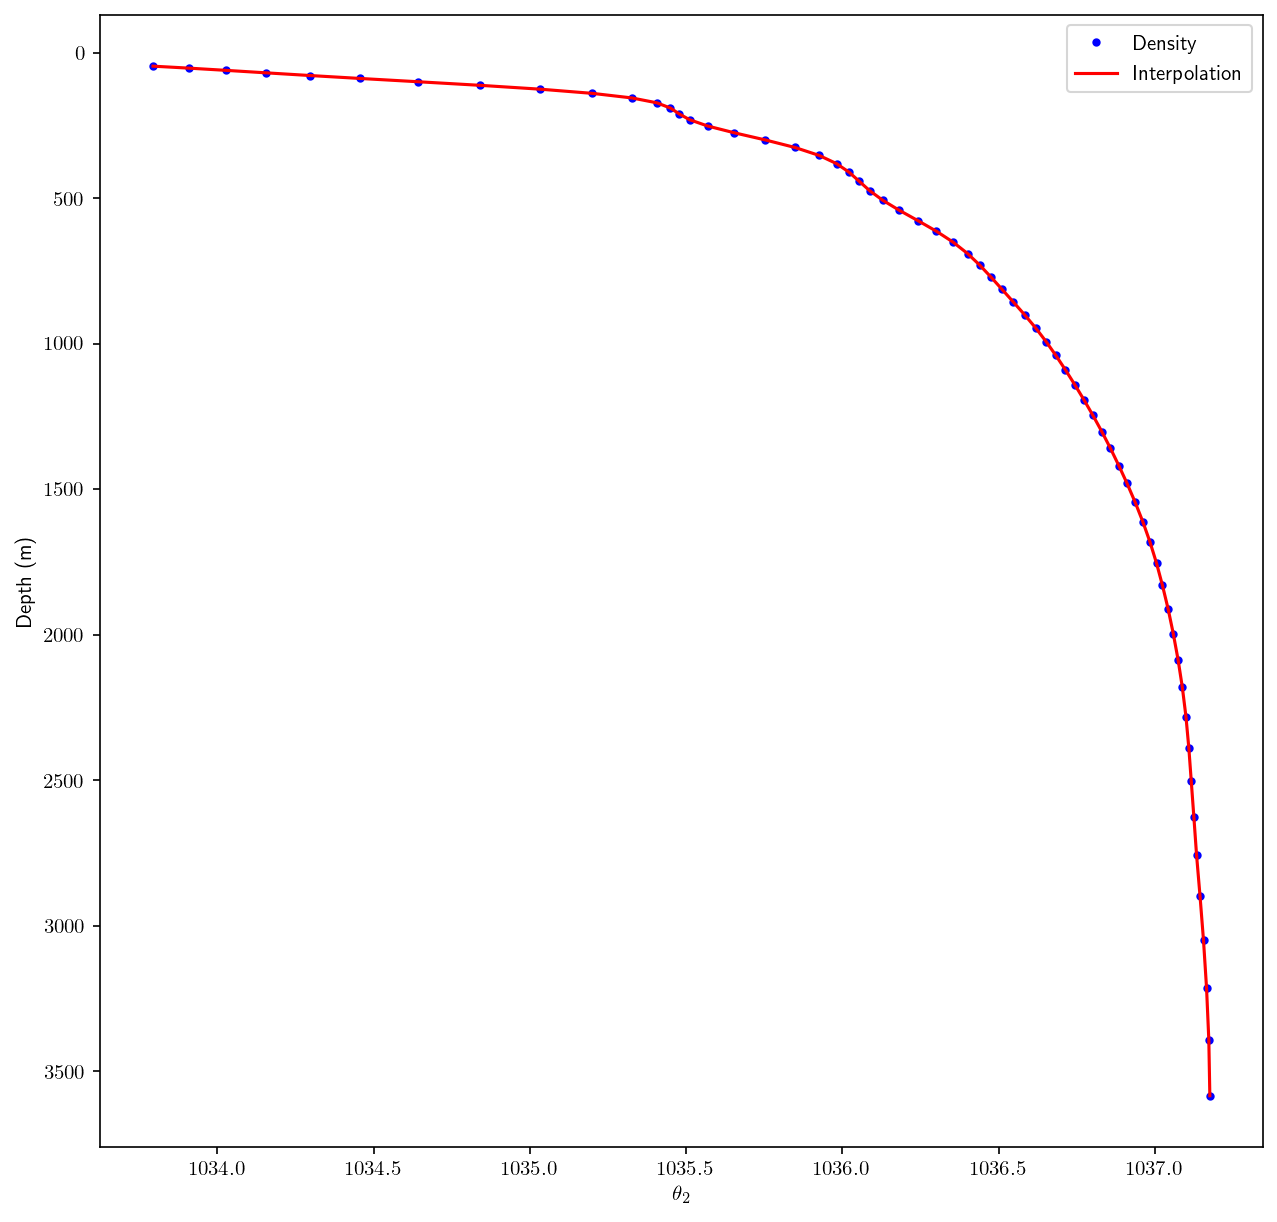

In [9]:
%matplotlib inline
f, ax = plt.subplots()
zofr_p = zofr.derivative()
ax.plot(R_mean,Z,'b.',  label='Density',)
ax.plot(R_mean,zofr(R_mean),'r-',label='Interpolation')
ax.invert_yaxis()
ax.set_xlabel(r"$\theta_{2}$")
ax.set_ylabel(r"Depth (m)")
ax.legend()
f.set_size_inches(10,10)
f.set_dpi(150)

(1999, 5)


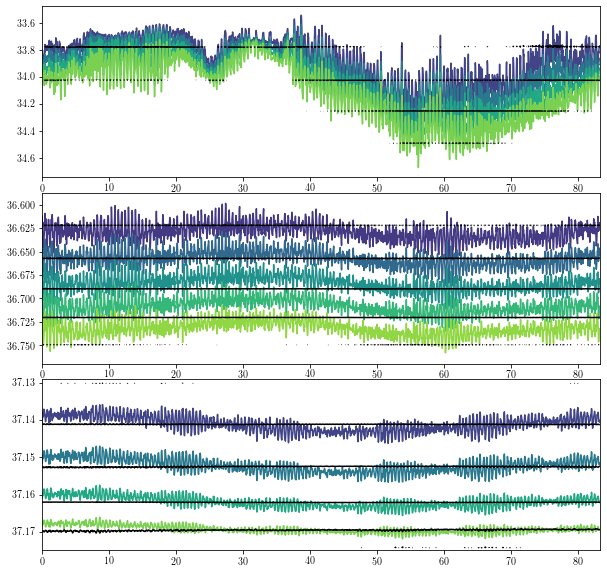

In [13]:
import matplotlib as mpl
f =  plt.figure()
gs = mpl.gridspec.GridSpec(ncols=1,nrows=6,figure=f)
ax0 = f.add_subplot(gs[0:2,0])
ax1 = f.add_subplot(gs[2:4,0])
ax2 = f.add_subplot(gs[4:6,0])
s1 = (slice(0,-1),slice(0,4),0,0)
s2 = (slice(0,-1),slice(35,40),0,0)
s3 = (slice(0,-1),slice(-6,-1),0,0)
ax0.contour(AX[s1]['t']/24,RP[s1]-1000,AX[s1]['z'],levels=4)
ax0.contour(AX[s1]['t']/24,RP[s1]-1000,zofr(RP[s1]),levels=4,colors='k')

ax1.contour(AX[s2]['t']/24,RP[s2]-1000,AX[s2]['z'],levels=5)
ax1.contour(AX[s2]['t']/24,RP[s2]-1000,zofr(RP[s2]),levels=5,colors='k')

ax2.contour(AX[s3]['t']/24,RP[s3]-1000,AX[s3]['z'],levels=5)
ax2.contour(AX[s3]['t']/24,RP[s3]-1000,zofr(RP[s3]),levels=5,colors='k')
#p = ax1.contourf(AX[s2]['t'],np.tile(R_mean[55:59],(200,1)),np.tile(Z[55:59],(200,1)),levels=10)


#p=ax.contourf(AX[s]['t'],RP[s],AX[s]['z'],levels=50,cmap='jet')
#p=ax.contourf(AX[s]['t'],AX[s]['z'],np.tile(R_mean[s[1]],(700,1)),levels=20)
ax0.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
#f.colorbar(p)
#f.autofmt_xdate(rotation=70)
f.set_size_inches(10,10)
print(RP[s2].shape)

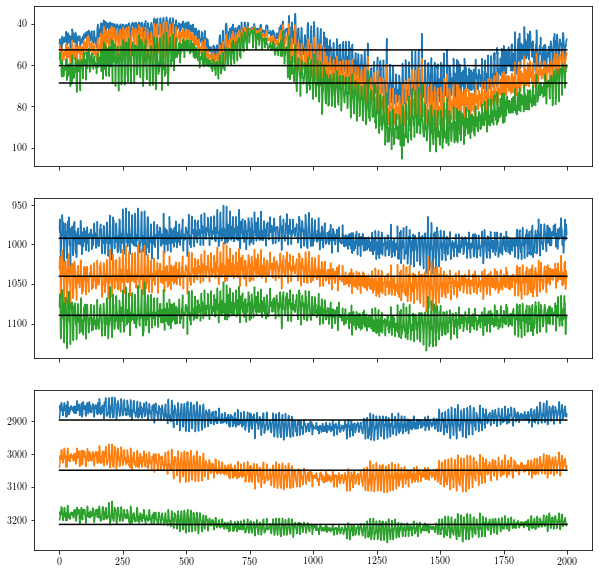

In [14]:
f , ax = plt.subplots(3,1,sharex=True)
ax[0].plot(zofr(RP[s1][:,1:4]))
ax[0].plot(AX[s1]['z'][:,1:4],'k-')

ax[1].plot(zofr(RP[s2][:,1:4]))
ax[1].plot(AX[s2]['z'][:,1:4],'k-')

ax[2].plot(zofr(RP[s3][:,1:4]))
ax[2].plot(AX[s3]['z'][:,1:4],'k-')

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

f.set_size_inches(10,10)

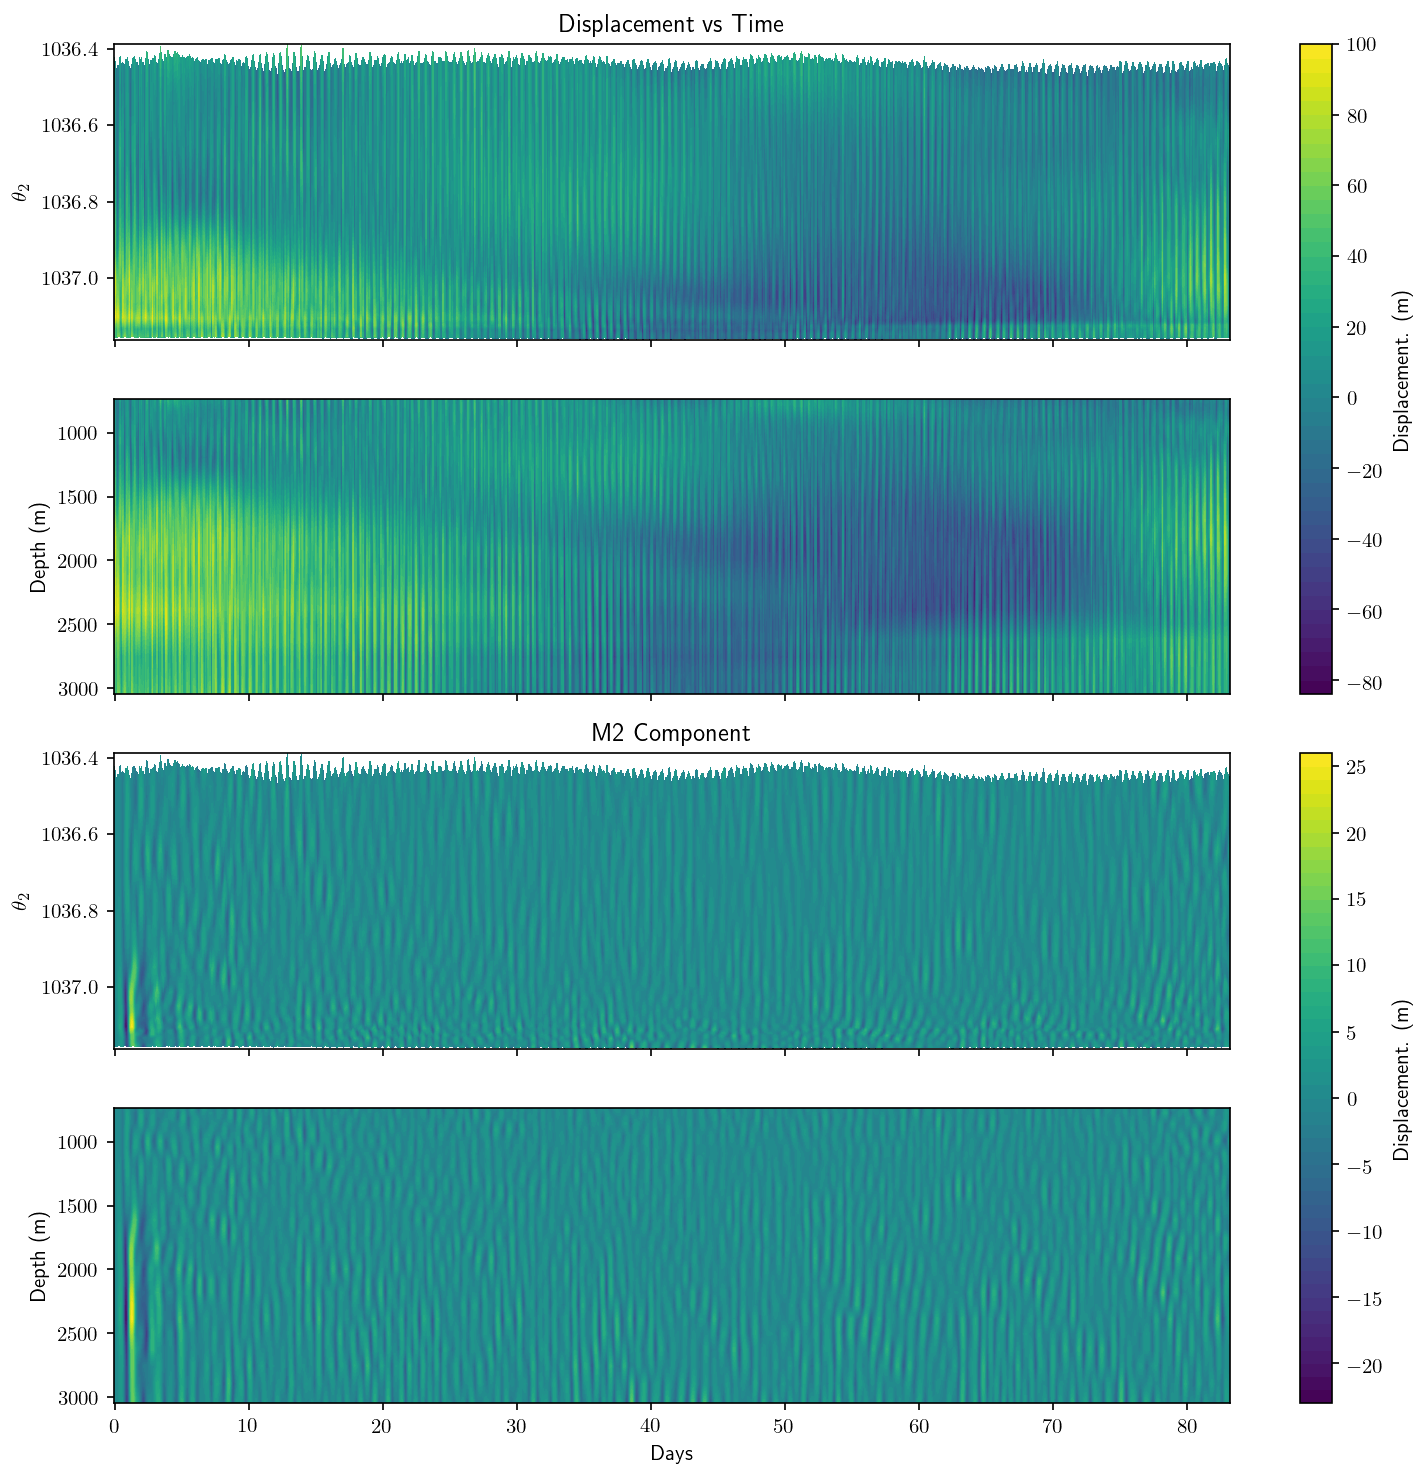

In [145]:
f,ax = plt.subplots(4,1,sharex=True)
s = (slice(0,-1),slice(30,-3),0,0)
p0=ax[0].contourf(AX[s]['t']/24,RP[s],DZ[s],levels=50)
p1=ax[1].contourf(AX[s]['t']/24,AX[s]['z'],DZ[s],levels=50)
p2=ax[2].contourf(AX[s]['t']/24,RP[s],DZB[s],levels=50)
p3=ax[3].contourf(AX[s]['t']/24,AX[s]['z'],DZB[s],levels=50)

for a in ax.ravel():
    a.invert_yaxis()

ax[0].set_title("Displacement vs Time")
ax[0].set_ylabel(r'$\theta_2$')
ax[1].set_ylabel('Depth (m)')

ax[2].set_title("M2 Component")
ax[2].set_ylabel(r'$\theta_2$')
ax[3].set_ylabel('Depth (m)')
ax[3].set_xlabel('Days')
f.colorbar(p0,ax=ax[:2],label="Displacement. (m)")
f.colorbar(p2,ax=ax[2:],label="Displacement. (m)")
f.set_size_inches(12,12)
f.set_dpi(150)


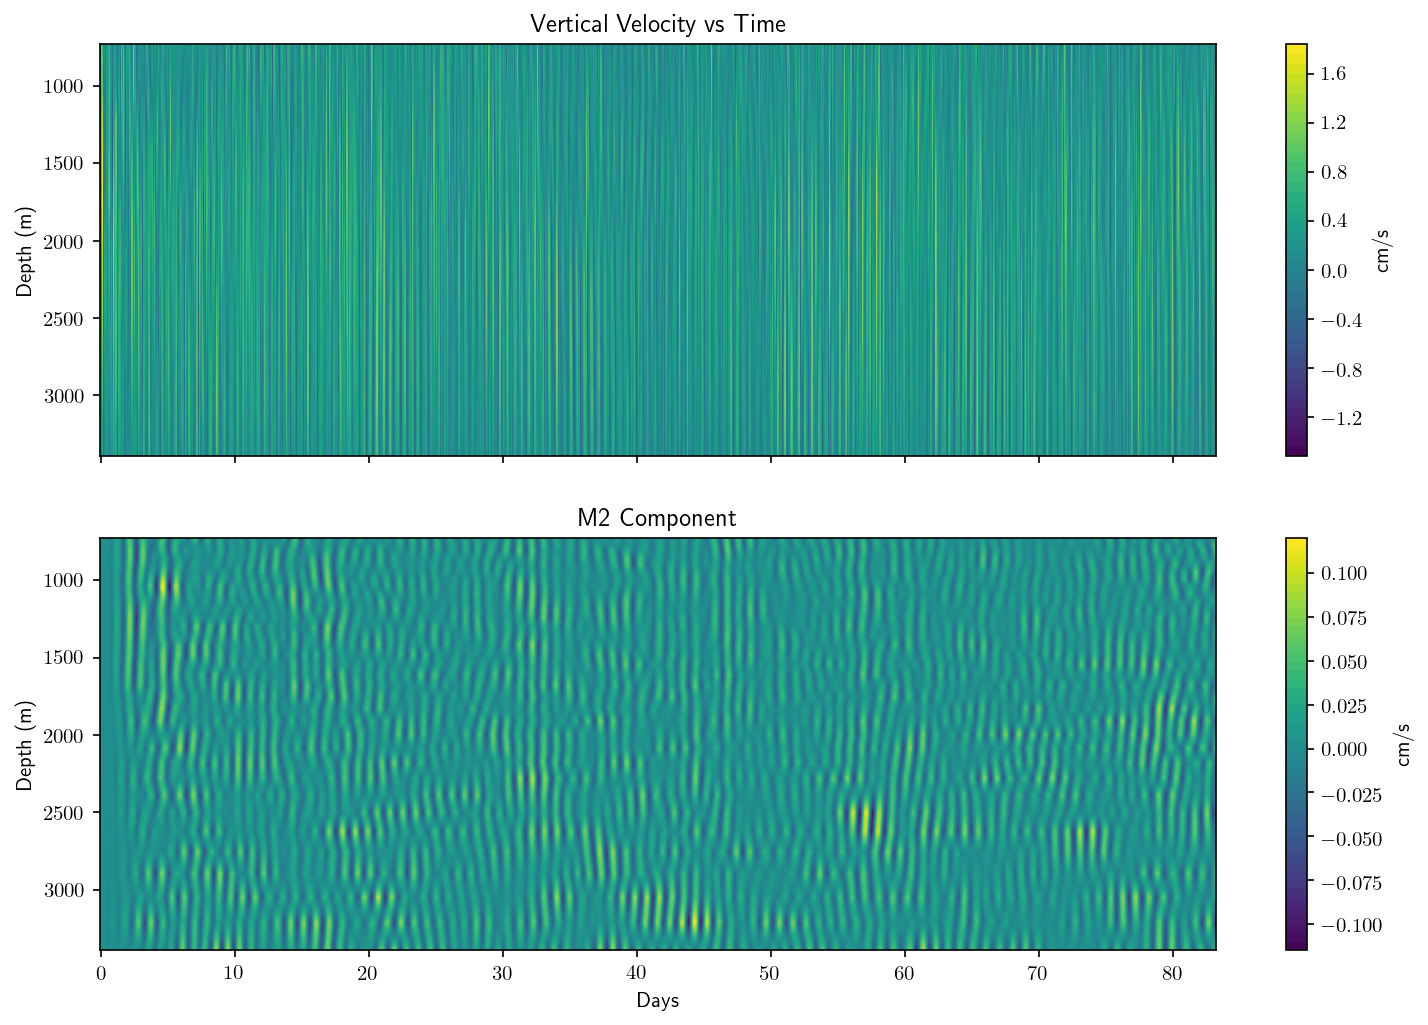

In [118]:
f,ax = plt.subplots(2,1,sharex=True)
s = (slice(0,2000),slice(30,-1),0,0)
p0 =ax[0].contourf(AX[s]['t']/24,AX[s]['z'],W[s],levels=50)
p1 = ax[1].contourf(AX[s]['t']/24,AX[s]['z'],WB[s],levels=50)

for a in ax.ravel():
    a.invert_yaxis()
    a.set_ylabel('Depth (m)')
ax[0].set_title('Vertical Velocity vs Time')
ax[1].set_title('M2 Component')
ax[1].set_xlabel('Days')

f.colorbar(p0,ax=ax[0],label='cm/s')
f.colorbar(p1,ax=ax[1],label='cm/s')
f.set_size_inches(12,8)
f.set_dpi(150)


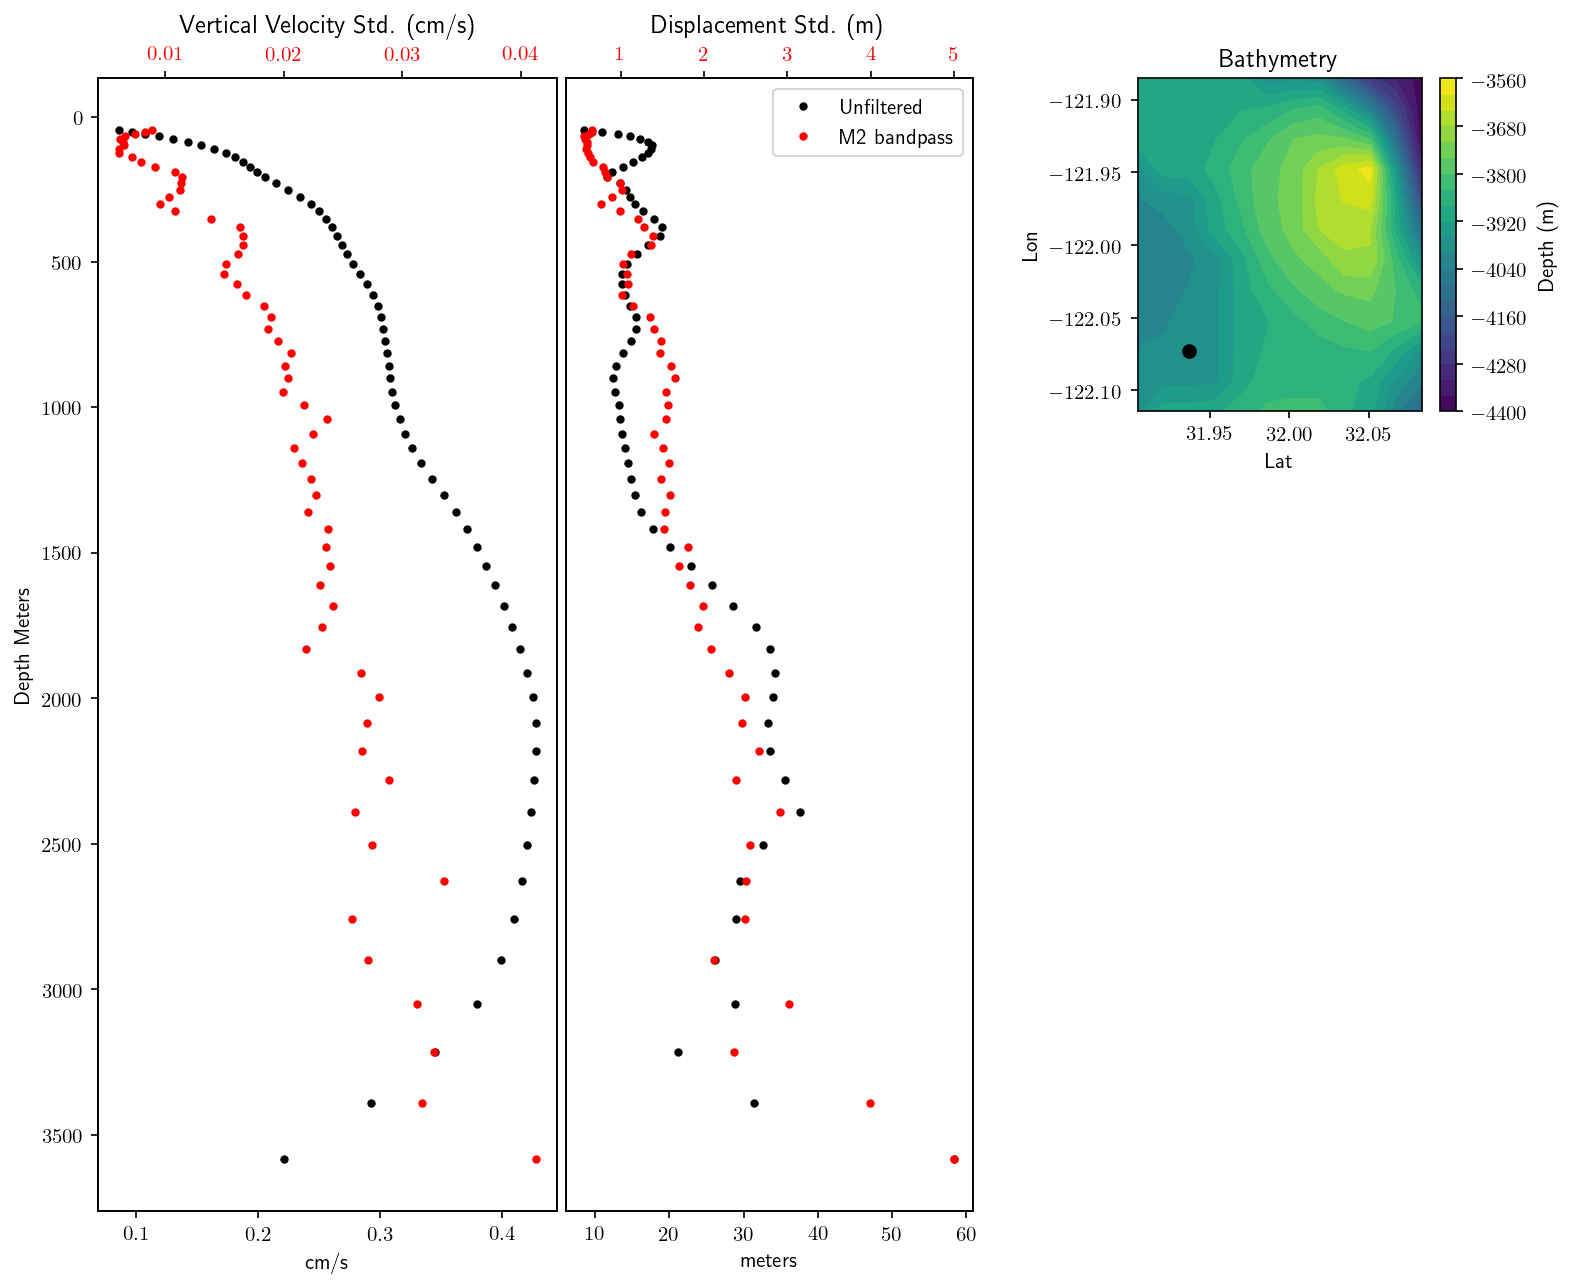

In [119]:
import matplotlib as mpl

f =  plt.figure()
gs = mpl.gridspec.GridSpec(ncols=27,nrows=3,figure=f)
ax0 = f.add_subplot(gs[:,0:9])
ax1 = f.add_subplot(gs[:,9:17])
ax2 = f.add_subplot(gs[:1,20:])

#Plot Vertical Velcoity
ax0.invert_yaxis()
ax0.set_title("Vertical Velocity Std. (cm/s)")
ax0.plot(np.std(W,axis=(0,2,3)),Z,'k.',)
ax0.set_xlabel('cm/s')
ax0.set_ylabel('Depth Meters')
axt0 = ax0.twiny()
axt0.plot(np.std(WB,axis=(0,2,3)),Z,'r.')
axt0.tick_params(axis='x', labelcolor='r')

#Plot Displacement
ax1.invert_yaxis()
ax1.set_title("Displacement Std. (m)")
ax1.set_yticks([])
ln = ax1.plot(np.std(DZ,axis=(0,2,3)),Z,'k.',label='Unfiltered')
ax1.set_xlabel('meters')
axt1 = ax1.twiny()
lnt = axt1.plot(np.std(DZB,axis=(0,2,3)),Z,'r.',label='M2 bandpass')
axt1.tick_params(axis='x', labelcolor='r')
lns = ln + lnt
ax1.legend(lns,[l.get_label() for l in lns],loc=0)

#Plot Topo
depth  = extract_node(table,'depth')
lat  = extract_node(table,'lat')
lon  = extract_node(table,'lon')
ax2.set_title("Bathymetry")
p = ax2.contourf(lat,lon,-depth,levels=20)
ax2.scatter(lat[2,2],lon[2,2],color='k')
ax2.set_ylabel('Lon')
ax2.set_xlabel('Lat')

f.colorbar(p,ax=ax2,label='Depth (m)')
f.set_size_inches(12,10)
f.set_dpi(150)

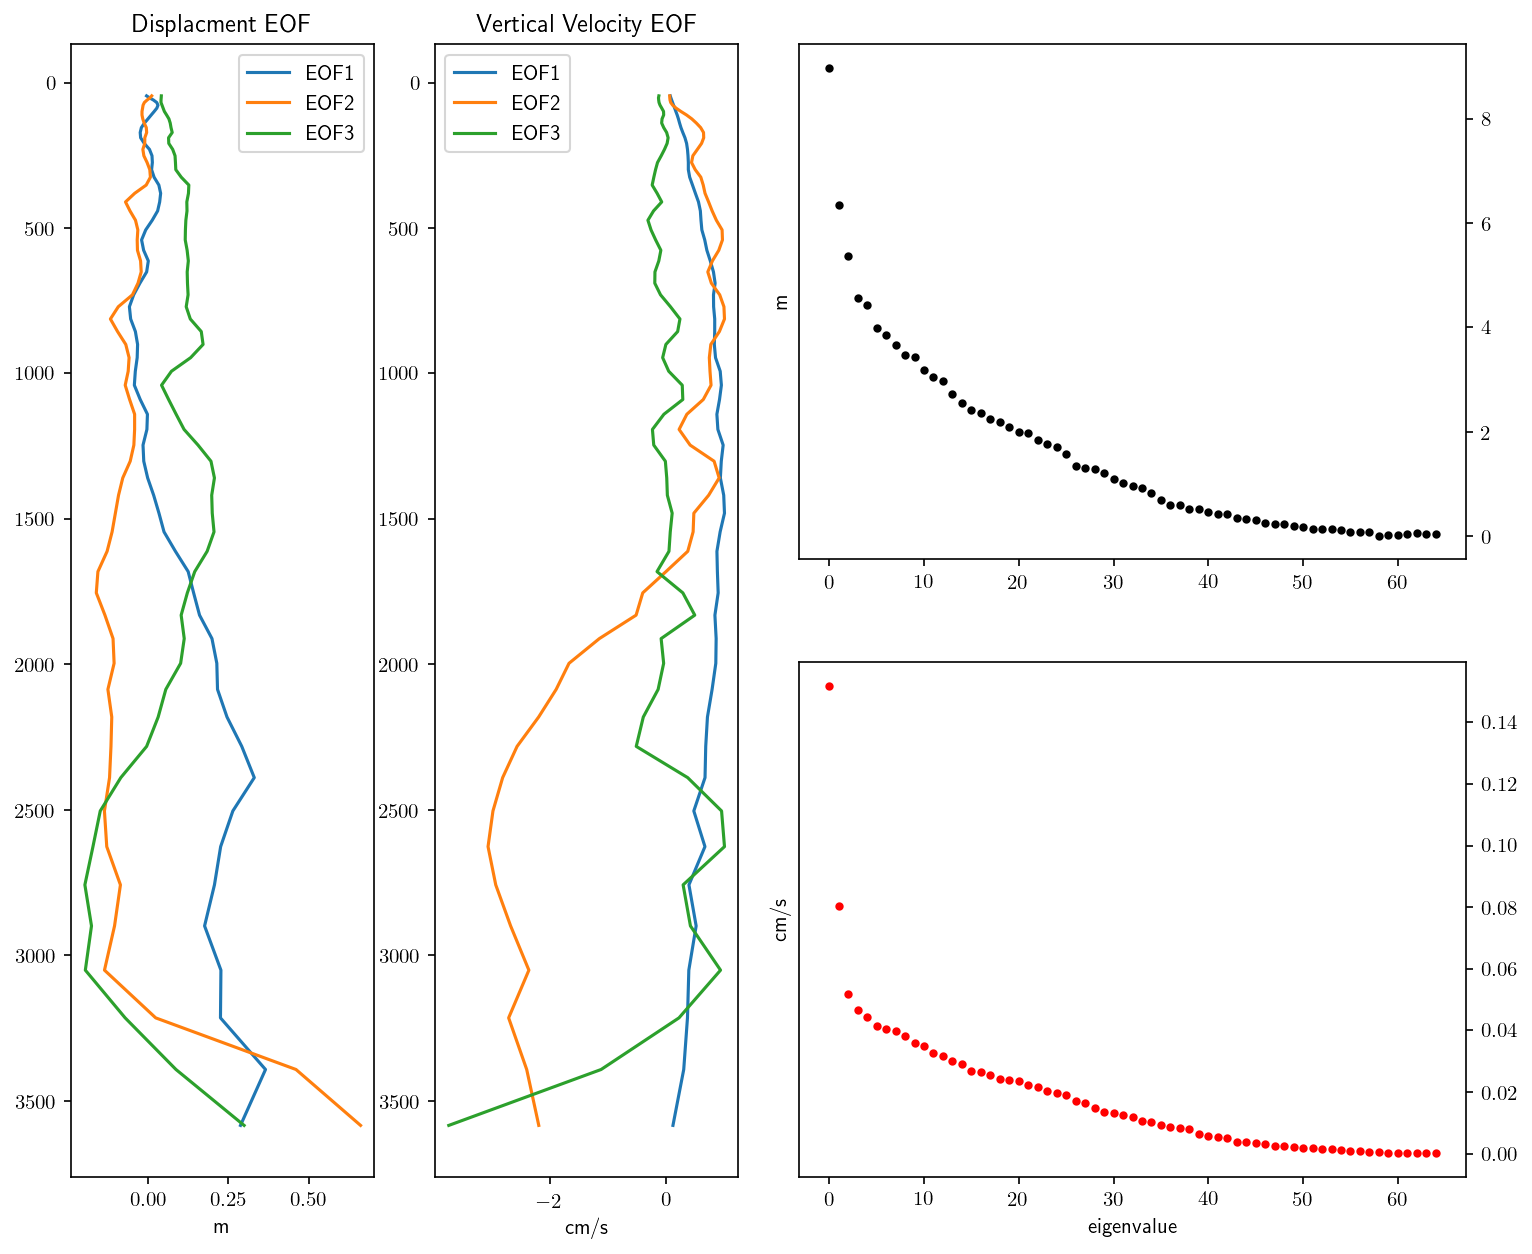

In [146]:
"""
PCA Analysis
"""
%matplotlib inline
import matplotlib as mpl

#TODO make generic EOF function
def EOF(data,ax):
    #Matrix of data
    #Dimension data is a function of
    
    #Demean
    axis = data.shape.pop(ax)
    avg = np.mean(data,axis=axis,keepdims=True)
    data = data-avg
    
    #Construct covariance
    dl = []
#WP = np.zeros(shape=DZ.shape)
#for i in range(DZ.shape[0]-1):
#    DZP[i,:,0,0] = DZ[i,:,0,0] - DB
#    #for j in range(DZ.shape[2]-1):
#        #for k in range(DZ.shape[3]-1):

#Stack in time and space
#DZPL = []
#for i in range(DZ.shape[2]-1):
#    for j in range(DZ.shape[3]-1):
#            DZPL.append(DZ[:,:,j,k])
#            
#DZP = np.concatenate(DZPL)
    
    

#Compute and then subtract the mean
WBAR = np.mean(WB,axis=(0,2,3),keepdims=True)
DBAR = np.mean(DZB,axis=(0,2,3),keepdims=True)

DZP = DZB - DBAR
WP  = WB - WBAR

R_D = np.cov(DZP[:,:,0,0].T)
R_W = np.cov(WP[:,:,0,0].T)

dl,de  = np.linalg.eig(R_D)
wl,we  = np.linalg.eig(R_W)

f  =  plt.figure()
gs = mpl.gridspec.GridSpec(2,4)

ax = f.add_subplot(gs[0:2,0])
for i in range(0,3):
    ax.plot(de[:,i],Z,label='EOF%d' % (i+1))
ax.set_xlabel("m")
ax.invert_yaxis()
ax.legend()
ax.set_title("Displacment EOF")

ax1 = f.add_subplot(gs[0:2,1])
for i in range(0,3):
    ax1.plot(we[:,i]/max(we[:,i]),Z,label='EOF%d' % (i+1))
ax1.set_xlabel("cm/s")
ax1.invert_yaxis()
ax1.legend()
ax1.set_title("Vertical Velocity EOF")

    
ax2 = f.add_subplot(gs[0:1,2:])
ax2.plot(np.sqrt(dl),'k.')
ax2.set_ylabel('m')
ax2.yaxis.tick_right()

ax3 = f.add_subplot(gs[1:,2:])
ax3.plot(np.sqrt(wl),'r.')
ax3.yaxis.tick_right()
ax3.set_ylabel('cm/s')
ax3.set_xlabel('eigenvalue')

f.set_size_inches(12,10)
f.set_dpi(150)

(2000, 65) (65, 65)


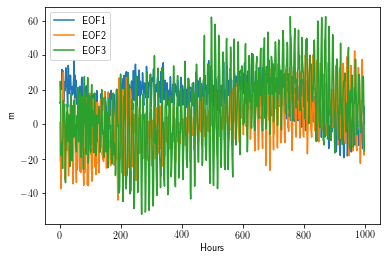

In [147]:
DZP = DZ[:,:,0,0]
print(DZP.shape,v.shape)
u = DZP @ v.T
f , ax = plt.subplots()
ax.plot(u[0:1000,0],label="EOF1")
ax.plot(u[0:1000,1],label="EOF2")
ax.plot(u[0:1000,2],label="EOF3")
ax.set_xlabel("Hours")
ax.set_ylabel("m")
ax.legend()
#ax.plot(DZP[0:200,0])

In [ ]:
mask = extract_node(table,'mask')
Tm = np.ma.masked_array(T[0,:,:,:],mask=np.isnan(mask))
plt.contourf(Tm[0,:,:])
plt.colorbar()